## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser.

----

This notebook performs Bayesian Optimizaion using GPytorch of the Lund string model parameters that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{1}{z^{1+r_Q b m_Q^2}}(1-z)^{a'_i} \exp \left(-\frac{b m_{\perp}^2}{z}\right),
$$

As well as other important flavor and shower parameters. For detailed description of these parameters, see my overleaf writeup.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

In [1]:
import numpy as np
from scipy.stats import qmc
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
MAX_PROB = 4.0
PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0.2, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        # 'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        # 'StringPT:sigma':[0.,1.],
        # 'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,MAX_PROB],
        # 'StringFlav:ProbStoUD':[0,MAX_PROB],
        # 'StringFlav:probQQtoQ':[0,MAX_PROB],
        # 'StringFlav:probSQtoQQ':[0,MAX_PROB],
        # 'StringFlav:ProbQQ1toQQ0':[0,MAX_PROB],
        # 'TimeShower:alphaSvalue':[0.06,0.25],
        # 'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    # "rFactC": 1.32,
    # "rFactB":0.855,
    # "aExtraSQuark": 0.0,
    # "aExtraDiquark":0.97,
    # "sigma":0.335,
    # "enhancedFraction":0.01,
    # "enhancedWidth":2.0,
    # "ProbStoUD":0.217,
    # "probQQtoQ":0.081,
    # "probSQtoQQ":0.915,
    # "ProbQQ1toQQ0": 0.0275,
    # "alphaSvalue": 0.1365,
    # "pTmin": 0.5
}

REDUCED_MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "aExtraSQuark": 0.0,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}


def get_param_prefix(param):
    for key,val in PARAM_DICT.items():
        prefix, postfix = key.split(':')
        if postfix == str(param):
            return prefix

param_names = list(PARAM_DICT.keys())
print(len(PARAM_DICT))

2


## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

We use the following test statistic
$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2},
$$
where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

In [90]:
def make_pythia_card(aLund, 
                     bLund,
                    # rFactC,
                    # rFactB,
                    # aExtraSQuark,
                    # aExtraDiquark,
                    # sigma,
                    # enhancedFraction,
                    # enhancedWidth,
                    # ProbStoUD,
                    # probQQtoQ,
                    # probSQtoQQ,
                    # ProbQQ1toQQ0,
                    # alphaSvalue,
                    # pTmin
                    ):
    
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 2500          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        # f.write(f"StringZ:rFactC = {rFactC}\n\n")
        # f.write(f"StringZ:rFactB = {rFactB}\n\n")
        # f.write(f"StringZ:aExtraSQuark = {aExtraSQuark}\n\n")
        # f.write(f"StringZ:aExtraDiquark = {aExtraDiquark}\n\n")
        # f.write(f"StringPT:sigma = {sigma}\n\n")
        # f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        # f.write(f"StringPT:enhancedWidth = {enhancedWidth}\n\n")
        # f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        # f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        # f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        # f.write(f"StringFlav:ProbQQ1toQQ0 = {ProbQQ1toQQ0}\n\n")
        # f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        # f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [91]:
def reduce_filtered_keys(filtered_data_keys, filtered_mc_keys):
    # Initialize empty list for the reduced keys
    reduced_data_keys = []
    reduced_mc_keys = []
    # List of histogram keys that need to be removed
    hists_to_remove = ['d35-x01-y01', 'd36-x01-y01', 'd39-x01-y01', 'd40-x01-y01']
    
    # Iterate over each data key
    for data_key in filtered_data_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(data_key) for hist_to_remove in hists_to_remove):
            reduced_data_keys.append(data_key)

    for mc_key in filtered_mc_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(mc_key) for hist_to_remove in hists_to_remove):
            reduced_mc_keys.append(mc_key)
            
        
    return reduced_data_keys, reduced_mc_keys

        

In [92]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import *

def true_objective_func(aLund, 
                     bLund,
                    # rFactC,
                    # rFactB,
                    # aExtraSQuark,
                    # aExtraDiquark,
                    # sigma,
                    # enhancedFraction,
                    # enhancedWidth,
                    # ProbStoUD,
                    # probQQtoQ,
                    # probSQtoQQ,
                    # ProbQQ1toQQ0,
                    # alphaSvalue,
                    # pTmin
                       ):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                     bLund,
                    # rFactC,
                    # rFactB,
                    # aExtraSQuark,
                    # aExtraDiquark,
                    # sigma,
                    # enhancedFraction,
                    # enhancedWidth,
                    # ProbStoUD,
                    # probQQtoQ,
                    # probSQtoQQ,
                    # ProbQQ1toQQ0,
                    # alphaSvalue,
                    # pTmin
                    )
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 4.5: take out bad histograms
    reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)

    
    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(reduced_data_keys,
                                         reduced_mc_keys, 
                                         dfdata, 
                                         dfsims[gen_ind], 
                                         which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
            
    objective_func = X0[0]
        
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

## Gaussian Process Regression

A data set $\mathcal{D}= \left\{ \mathbf{x}, \mathbf{y} \right\} = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

The assumption is that the actual observations are a noise-corrupted value of the true model:
$$
y = f(x) + \varepsilon, \tag{1}
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise. FOr example, the model could be $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}$.  

In general, the posterior predictive distribution marginalizes over the model parameters $w$:

$$ p(y \mid x, \mathcal{D}) = \int p(y, w \mid x, \mathcal{D}) d w = \int p(y \mid x, w) p(w \mid \mathcal{D}) dw \tag{2}$$

Using Eq. (1), one can write the likelihood, which is Gaussian

$$p(y \mid w) = p(y \mid x, w) = \mathcal{N}(y; f(x), \sigma^2)$$

However, the integral in Eq. (1) is intractable in closed form. The trick is realizing that the first term in Eq. (1) is a Gaussian. Furthermore, $p(w \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid w) p(w)}{Z}$ is a product of Gaussians normalized by a Gaussian, so it is also a Gaussian, therefore, $p(y \mid x, \mathcal{D}) $ is a Gaussian.


$p(\mathbf{y}\mid\mathbf{x})$ is thus fully specified by the Kernel, and it starts out being the Gaussian process prior
$$ p(y_1, ... y_n \mid x_1, .., x_n)  = \mathcal{N}(y;0, \Sigma) \tag{3}$$ 
Where, $\Sigma$ can be decomposed as

$$ \Sigma =  \begin{pmatrix}
k & k_* \\
k_*^T & k_{**}
\end{pmatrix} $$

Another way to write Eq. (3) is
$$ \left[\begin{array}{c}
f\left(x^*\right) \\
f\left(x_1\right) \\
\vdots \\
f\left(x_n\right)
\end{array}\right] \sim N\left(\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0
\end{array}\right],\left[\begin{array}{cc}
k\left(x^*, x^*\right) & k\left(x^*, \mathbf{x}\right)^T \\
k\left(x^*, \mathbf{x}\right) & K_{\mathbf{x x}}
\end{array}\right]\right)$$


where the the kernel components $k$'s are functions of $x_1,...,x_n$ and $x_*$
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$

The most commonly used kernel is the RBF kernel  $\Sigma_{x,y} = k(x, y) = \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where $l$ is a `lengthscale`.  There is usually a multiplicative constant in front which controls the amplitude, and can be accessed with `ScaleKernel(RBFKernel())`.

Automatic Relevance Determination (ARD) kernel can be useful if input features have varying scales or relevance. ARD can adapt different lengthscales for each dimension of the input space.

Now, given a new data point $x^*$, $y^*$ can be predicted using a closed form of the posterior predictive distribution
$$
y_* | \mathcal{D}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)), \tag{4}
$$

That is, the Gaussian process at a new point $\mathbf{x}^*$ is
$$p\left(f\left(\mathbf{x}^*\right) \mid \mathbf{y}\right)=\mathcal{N}\left(f\left(\mathbf{x}^*\right) \mid m \left(\mathbf{x}^*\right), \sigma \left(\mathbf{x}^*\right)\right)$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$

$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$



In [93]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=train_x.size(-1)))
        # self.covar_module = ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=train_x.size(-1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

A rule of thumb is to choose the training set size to be 10-20 times the number of parameters. This gives us 150-300 examples.

### (Optional) Make new dataset here in jupyter

In [94]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        self.min = PARAM_DICT[pre_postfix][0]
        self.max = PARAM_DICT[pre_postfix][1]
        
    def uniform(self):
        return torch.tensor(np.random.uniform(
                low=self.min,
                high=self.max,
                size=self.size))

    def linspace(self):
        return torch.linspace(start=self.min,
                end=self.max,
                steps=self.size)

    def scale_sample(self, sample):
        return sample * (self.max - self.min) + self.min

In [95]:
def make_train_dataset(PARAM_DICT, points):
    param_names = list(PARAM_DICT.keys())
    column_names = param_names + ['chi2']
    
    rows = []
    for _ in range(points):
        row = []
        for param_name, range_ in PARAM_DICT.items():
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            row.append(uniform_size_1)
        
        chi2 = true_objective_func(*row)
        row.append(chi2)
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=column_names)
    return df

In [11]:
train_df_new = make_train_dataset(PARAM_DICT, 15)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:54:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:54:13
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:54:13, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.39it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.040000  1.0432  0.047763  0.037357       163.0
1  0.005  0.010  22.400000  1.7920  0.167561  0.260005       280.0
2  0.010  0.015  21.120001  1.6896  0.264335  0.670965       264.0
3  0.015  0.020  17.440001  1.3952  0.304142  1.068453       218.0
4  0.020  0.025  13.360000  1.0688  0.299245  1.345998       167.0
 new data keys ['/

objective function = 1.930181826919288

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:54:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:54:19
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:54:20, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.05it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.080000  0.4864  0.022775  0.018169        76.0
1  0.005  0.010  20.160000  1.6128  0.153100  0.240533       252.0
2  0.010  0.015  21.600000  1.7280  0.267902  0.672973       270.0
3  0.015  0.020  18.959999  1.5168  0.330867  1.162702       237.0
4  0.020  0.025  15.440000  1.2352  0.347859  1.573378       193.0
 new data keys ['/

objective function = 2.812539591986399

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:54:24
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:54:26
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:54:26, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.12it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.360000  0.7488  0.032661  0.024571       117.0
1  0.005  0.010  17.920000  1.4336  0.136601  0.215372       224.0
2  0.010  0.015  20.879999  1.6704  0.257376  0.643236       261.0
3  0.015  0.020  17.440001  1.3952  0.301791  1.051690       218.0
4  0.020  0.025  12.720000  1.0176  0.283664  1.270649       159.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:54:30
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:54:32
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:54:32, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.91it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.040000  0.4032  0.018739  0.015039        63.0
1  0.005  0.010  18.320000  1.4656  0.140528  0.223124       229.0
2  0.010  0.015  20.879999  1.6704  0.260646  0.659126       261.0
3  0.015  0.020  18.639999  1.4912  0.325575  1.144878       233.0
4  0.020  0.025  14.720000  1.1776  0.329961  1.485914       184.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:54:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:54:38
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:54:38, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.12it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.840000  0.6272  0.027478  0.020853        98.0
1  0.005  0.010  21.520000  1.7216  0.163062  0.256444       269.0
2  0.010  0.015  20.240000  1.6192  0.248675  0.618686       253.0
3  0.015  0.020  17.360001  1.3888  0.302848  1.064476       217.0
4  0.020  0.025  15.040000  1.2032  0.336335  1.510629       188.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:54:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:54:44
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:54:44, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.08it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.640000  0.6912  0.031811  0.024934       108.0
1  0.005  0.010  21.840000  1.7472  0.164469  0.256468       273.0
2  0.010  0.015  20.719999  1.6576  0.261336  0.667593       259.0
3  0.015  0.020  16.080000  1.2864  0.281289  0.991020       201.0
4  0.020  0.025  12.160000  0.9728  0.272206  1.223726       152.0
 new data keys ['/

objective function = 1.8202683432043087

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:54:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:54:50
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:54:50, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.14it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.320000  0.6656  0.027763  0.020450       104.0
1  0.005  0.010  22.240000  1.7792  0.169910  0.267553       278.0
2  0.010  0.015  22.639999  1.8112  0.278734  0.695434       283.0
3  0.015  0.020  18.879999  1.5104  0.328442  1.150833       236.0
4  0.020  0.025  14.480000  1.1584  0.325386  1.468932       181.0
 new data keys ['/

objective function = 2.0433339608566383

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:54:53
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 20:54:56
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:54:56, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.26it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.92  0.4736  0.021471  0.016611        74.0
1  0.005  0.010  20.48  1.6384  0.157151  0.249299       256.0
2  0.010  0.015  21.60  1.7280  0.271754  0.691785       270.0
3  0.015  0.020  18.32  1.4656  0.315443  1.093868       229.0
4  0.020  0.025  14.24  1.1392  0.318651  1.431817       178.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 2.9249885548422676

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:54:59
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 20:55:02
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:55:02, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.96it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.680000  0.4544  0.020556  0.015965        71.0
1  0.005  0.010  18.000000  1.4400  0.137486  0.217247       225.0
2  0.010  0.015  21.200001  1.6960  0.268086  0.686684       265.0
3  0.015  0.020  18.400000  1.4720  0.321878  1.134198       230.0
4  0.020  0.025  13.760000  1.1008  0.308123  1.386022       172.0
 new data keys ['/

objective function = 3.5180858619498068

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:55:05
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 20:55:08
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:55:08, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.08it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.040000  0.7232  0.030912  0.023085       113.0
1  0.005  0.010  20.719999  1.6576  0.152924  0.233986       259.0
2  0.010  0.015  20.879999  1.6704  0.256984  0.641755       261.0
3  0.015  0.020  18.000000  1.4400  0.314038  1.103178       225.0
4  0.020  0.025  13.440000  1.0752  0.299137  1.336944       168.0
 new data keys ['/

objective function = 1.966005710107652

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:55:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:55:13
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:55:13, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.15it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.240000  0.3392  0.014058  0.010466        53.0
1  0.005  0.010  18.799999  1.5040  0.145402  0.232447       235.0
2  0.010  0.015  19.520000  1.5616  0.243801  0.617246       244.0
3  0.015  0.020  18.080000  1.4464  0.315368  1.107151       226.0
4  0.020  0.025  13.440000  1.0752  0.302032  1.363023       168.0
 new data keys ['/

objective function = 3.9842449612464903

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:55:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:55:19
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:55:19, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.44it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  17.600000  1.4080  0.059847  0.044552       220.0
1  0.005  0.010  25.600000  2.0480  0.190591  0.294375       320.0
2  0.010  0.015  20.400000  1.6320  0.255180  0.647484       255.0
3  0.015  0.020  16.559999  1.3248  0.288932  1.014793       207.0
4  0.020  0.025  11.680000  0.9344  0.264006  1.198083       146.0
 new data keys ['/

objective function = 2.256953547225373

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:55:23
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:55:25
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:55:25, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.57it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.960000  1.0368  0.042717  0.031523       162.0
1  0.005  0.010  23.360001  1.8688  0.176041  0.275841       292.0
2  0.010  0.015  19.280001  1.5424  0.239577  0.603313       241.0
3  0.015  0.020  15.440000  1.2352  0.267965  0.936021       193.0
4  0.020  0.025  12.160000  0.9728  0.273499  1.234812       152.0
 new data keys ['/

objective function = 1.7311859281366193

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:55:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:55:31
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:55:31, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.63it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  15.280000  1.2224  0.050721  0.036956       191.0
1  0.005  0.010  26.000000  2.0800  0.192208  0.294450       325.0
2  0.010  0.015  21.440001  1.7152  0.265104  0.664565       268.0
3  0.015  0.020  16.879999  1.3504  0.294190  1.032197       211.0
4  0.020  0.025  14.240000  1.1392  0.317602  1.422739       178.0
 new data keys ['/

objective function = 2.8508814278034276

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:55:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:55:37
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:55:37, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.56it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  15.760000  1.2608  0.050422  0.036584       197.0
1  0.005  0.010  24.559999  1.9648  0.180289  0.274167       307.0
2  0.010  0.015  19.920000  1.5936  0.245855  0.614968       249.0
3  0.015  0.020  15.520000  1.2416  0.269906  0.945410       194.0
4  0.020  0.025  12.880000  1.0304  0.288235  1.295053       161.0
 new data keys ['/

objective function = 2.296067706104047


In [96]:
train_df_new.describe()

,StringZ:aLund,StringZ:bLund,chi2
count,15.000000,15.000000,15.000000
mean,1.170964,1.031369,2.529398
std,0.589671,0.393559,0.717184
min,0.353689,0.436883,1.731186
25%,0.597740,0.654008,1.948094
50%,1.323333,1.158522,2.296068
75%,1.713616,1.350831,2.887935
max,1.952970,1.703173,3.984245


In [97]:
train_x = train_df_new[param_names].to_numpy()
train_y = train_df_new['chi2'].to_numpy()
train_x.shape

(15, 2)

## Define model and likelihood

The surrogate model of the output $\mathbf{y}$ is $\mathbf{f}=\left[f\left(\mathbf{x}_1\right), \ldots, f\left(\mathbf{x}_N\right)\right]^{\top}$ and it follows a multivariate Gaussian $p(\mathbf{f})=\mathcal{N}(\mathbf{f} \mid \mathbf{m}, \mathbf{K})$ where $\mathbf{m}=\left[m\left(\mathbf{x}_1\right), \ldots, m\left(\mathbf{x}_N\right)\right]^{\top}$ is the mean value function and $\mathbf{K}$ is the kernel matrix $[\mathbf{K}]_{i j}=\kappa\left(\mathbf{x}_i, \mathbf{x}_j\right)$. The likelihood in GPytorch maps from the latent function values $\mathbf{f}$ to the observed labels $\mathbf{y}$. Since we assume that the labels are noise-corrupted observations of the true model,
$$y(\mathbf{x})=f(\mathbf{x})+\epsilon, \quad \epsilon \sim N\left(0, \sigma_n^2 \mathbf{I}\right)$$
and therefore
$$ p(\mathbf{y} \mid \mathbf{f})=\mathcal{N}\left(\mathbf{y} \mid \mathbf{f}, \sigma^2 \mathbf{I}\right)$$

where $\sigma^2$ is the likelihood noise variance.

In [98]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)

model = GPModel(train_x = train_x, train_y=train_y, likelihood=likelihood).double()

In [99]:
model.train_targets

tensor([1.9302, 2.8125, 2.3056, 3.5982, 1.9024, 1.8203, 2.0433, 2.9250, 3.5181,
        1.9660, 3.9842, 2.2570, 1.7312, 2.8509, 2.2961], dtype=torch.float64)

In [100]:
model.train_inputs[0].shape

torch.Size([15, 2])

In [101]:
def make_x_candidates(PARAM_DICT, size):
    """
    Example: x_candidates = make_x_candidates(PARAM_DICT,2)
    """
    full_matrix = np.empty((size, len(PARAM_DICT)))
    
    for row in range(size):
        result=[]
        for key, val in PARAM_DICT.items():
            param_name, range_ = key, val
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            result.append(uniform_size_1)
        full_matrix[row,:] = result
        
    result = full_matrix
    
    # print(result)
    return torch.tensor(result)

In [102]:
def make_sobol_candidates(PARAM_DICT, size):
    num_params = len(PARAM_DICT)
    
    # Create a single Sobol sampler for all dimensions
    sampler = qmc.Sobol(d=num_params, scramble=True)
    
    # Generate samples
    samples = sampler.random(n=size)
    
    # Scale samples for each parameter
    scaled_samples = np.empty_like(samples)
    for ind, (key, val) in enumerate(PARAM_DICT.items()):
        param_name, range_ = key, val
        param_postfix = param_name.split(':')[1]
        param_sampler = Sample_param(param=param_postfix, size=size)
        scaled_samples[:, ind] = param_sampler.scale_sample(samples[:, ind])
    
    return torch.tensor(scaled_samples)


In [103]:
sobol_candidates = make_sobol_candidates(PARAM_DICT,1000)
print(sobol_candidates[:,1].min())

tensor(0.2004, dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


In [104]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates[0])

tensor([0.9607, 0.5562], dtype=torch.float64)


In [105]:
x_candidates_aLund =x_candidates[:,0]
print(x_candidates_aLund)

tensor([0.9607, 1.2809], dtype=torch.float64)


In [106]:
# make sure you can call model on x_candidates
model.predict(x_candidates)

MultivariateNormal(loc: torch.Size([2]))

In [107]:
def compare_uniform_sobol(PARAM_DICT,size):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    uniform_candidates = make_x_candidates(PARAM_DICT,size)
    a_uniform = uniform_candidates[:,0]
    b_uniform = uniform_candidates[:,1]
    ax[0].scatter(a_uniform, b_uniform)
    ax[0].set_title('Uniform MC')
    
    sobol_candidates = make_sobol_candidates(PARAM_DICT,size)
    a_sobol=sobol_candidates[:,0]
    b_sobol=sobol_candidates[:,1]
    ax[1].scatter(a_sobol, b_sobol)
    ax[1].set_title('Sobol')
    
    for i in range(2):
        ax[i].set_xlabel('aLund')
        ax[i].set_ylabel('bLund')
    plt.tight_layout()
    plt.show()

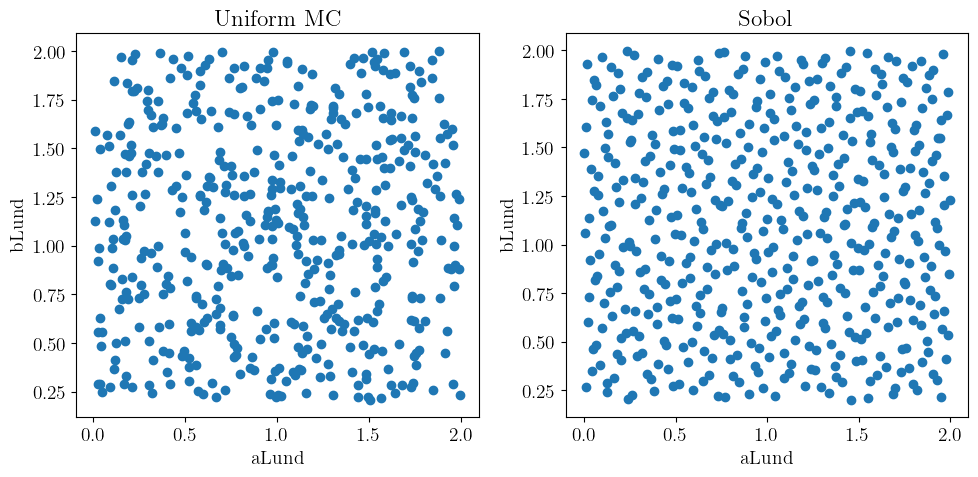

In [55]:
compare_uniform_sobol(PARAM_DICT,500)

In [108]:
def make_multidim_xstar(param,size):
    """
    This is used for sampling the parameters for plotting
    """
    x_star0 = Sample_param(param,size).linspace()
    # empty = np.ones((size,15))
    empty = make_x_candidates(PARAM_DICT, size)
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)
    empty[:,param_index] = x_star0
    # print(empty)
    return torch.tensor(empty)

In [391]:
x_star = make_multidim_xstar(param='bLund',size=2)
x_star

/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


tensor([[1.7990, 0.2000, 1.7004, 1.7913, 0.6428, 1.2323, 0.4865, 0.0626, 1.3514,
         0.9003, 2.8530, 0.1952, 3.7858, 0.0665, 1.8655],
        [1.4818, 2.0000, 1.6433, 1.9680, 0.5621, 1.0249, 0.2086, 0.8499, 2.2825,
         1.8680, 2.6426, 0.2238, 1.9430, 0.0618, 0.2708]], dtype=torch.float64)

In [392]:
train_x_model = model.train_inputs[0].numpy()
train_x_model[:,0]

array([1.01881549, 0.98871636, 0.44419299, ..., 1.36853655, 1.53483804,
       0.42838925])

In [109]:
def get_param_trainx(model, param):
    train_x = model.train_inputs[0].numpy()
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)
    
    train_x_param = train_x[:,param_index]
    return train_x_param

/tmp/ipykernel_5429/703769390.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


TypeError: Input z must be 2D, not 3D

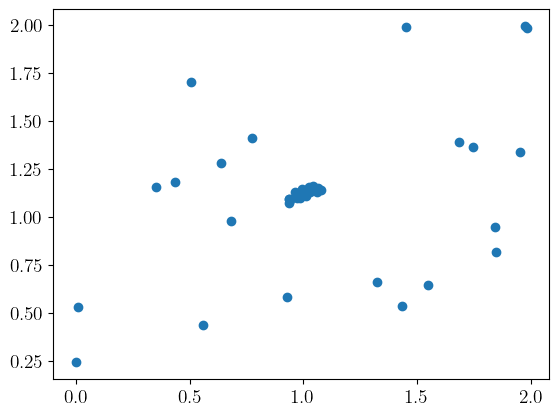

In [87]:
params = ['aLund', 'bLund']
param= params[0]
train_x_aLund = get_param_trainx(model, 'aLund')
train_x_bLund = get_param_trainx(model, 'bLund')

train_y = model.train_targets.numpy()

if train_x.shape[1] == 1 or train_x.ndim ==1:
    x_star = torch.linspace(train_x.min(), train_x.max(), 41)
else:
    # x_star = make_x_candidates(PARAM_DICT,200)
    x_star  = make_multidim_xstar(param,41)

model.eval()
predictive_distribution = model.predict(x_star)
lower, upper = predictive_distribution.confidence_region()
pred = predictive_distribution.mean.numpy()
plt.scatter(train_x_aLund, train_x_bLund)
X, Y = np.meshgrid(train_x_aLund, train_x_bLund)
pred = np.meshgrid(pred,pred)
plt.contourf(X,Y,pred, cmap='viridis')

In [110]:
def plot_model_param(model,param):
    train_x = model.train_inputs[0].numpy()
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)

    train_x_param = train_x[:,param_index]
    train_y = model.train_targets.numpy()
    
    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), 200)
    else:
        # x_star = make_x_candidates(PARAM_DICT,200)
        x_star  = make_multidim_xstar(param,200)
        
    model.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()
    
    print(pred.shape)

    x_star_param =x_star[:,param_index].numpy()
    plt.plot(x_star_param, pred, label='GP Mean Prediction', color='red')
    plt.fill_between(x_star_param, lower.numpy(), upper.numpy(), alpha=0.5)
    plt.plot(train_x_param, train_y, 'k*', label='Observed Data', alpha=0.5)
    plt.legend()
    plt.xlabel(param)
    plt.ylabel(r'$\lambda$')
    plt.show()

(200,)


/tmp/ipykernel_5429/703769390.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


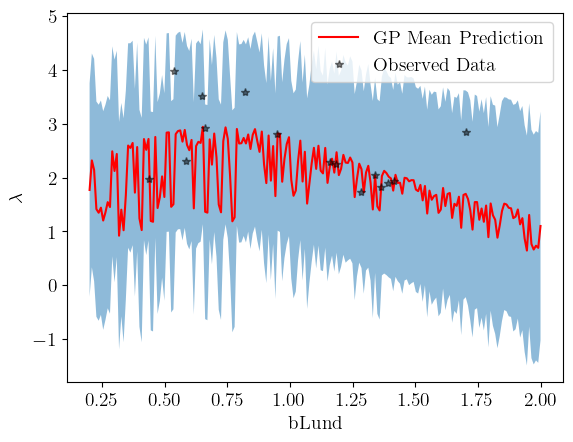

In [111]:
plot_model_param(model, 'bLund')

### Observe untrained (default) GP model parameters

In [112]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [113]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(0., dtype=torch.float64)
covar_module.raw_outputscale tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[0., 0.]], dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


## Tune hyperparameters of GP model (train model)

We tune the hyperparameters by maximizing the marginal log likelihood (MLL) (i.e. treating -MLL as the loss and minimizing it)

$$ \text{MLL} = p_f(\mathbf{y} \mid \mathbf{X})=\int p(\mathbf{y} \mid f(\mathbf{X})) p(f(\mathbf{X}) \mid \mathbf{X}) d f $$

For the Gaussian process this equates to 
$$p(\mathbf{y} \mid \mathbf{X})=\mathcal{N}\left(\mathbf{y} \mid \mathbf{m}, \mathbf{K}+\sigma^2 \mathbf{I}\right)$$
$$ \mathcal{L}= - \text{MLL}$$

In [114]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    
    # Optimize the model
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = - mll(output, train_y)
        if print_:
                print('Epoch %d/%d - Loss: %.3f   lengthscale: %s   noise: %.3f\n' % (
        epoch + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.tolist()[0],
        model.likelihood.noise.item()
    ))
        loss.backward()
        optimizer.step()

In [115]:
train_model(model, train_x, train_y, 15,print_=True)

Epoch 1/15 - Loss: 1.688   lengthscale: [0.6931471805599453, 0.6931471805599453]   noise: 0.693

Epoch 2/15 - Loss: 1.576   lengthscale: [0.7443966572816632, 0.7443966562298394]   noise: 0.644

Epoch 3/15 - Loss: 1.483   lengthscale: [0.7974775469029988, 0.7970230475415614]   noise: 0.598

Epoch 4/15 - Loss: 1.405   lengthscale: [0.8517373179661232, 0.8498916737630735]   noise: 0.554

Epoch 5/15 - Loss: 1.339   lengthscale: [0.9063941954441129, 0.9016065664850896]   noise: 0.513

Epoch 6/15 - Loss: 1.285   lengthscale: [0.9605675632905398, 0.9505651537990005]   noise: 0.474

Epoch 7/15 - Loss: 1.239   lengthscale: [1.013309817018107, 0.9950427314892734]   noise: 0.437

Epoch 8/15 - Loss: 1.201   lengthscale: [1.0636347739262901, 1.033306796419081]   noise: 0.402

Epoch 9/15 - Loss: 1.168   lengthscale: [1.1105404015517717, 1.0637572428391735]   noise: 0.370

Epoch 10/15 - Loss: 1.140   lengthscale: [1.1530273999139165, 1.0850807449292623]   noise: 0.341

Epoch 11/15 - Loss: 1.115   len

In [116]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([-1.4717], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(1.3203, dtype=torch.float64)
covar_module.raw_outputscale tensor(1.2292, dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[0.9366, 0.5563]], dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


/tmp/ipykernel_5429/703769390.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


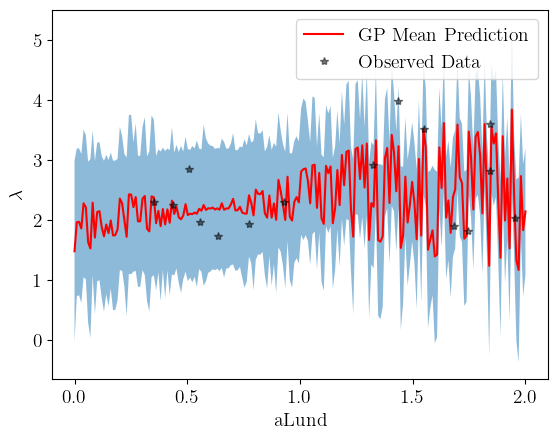

In [117]:
plot_model_param(model, 'aLund')

In [118]:
def get_observed_best_parameters(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    observed_min = train_x[train_y.argmin()]
    param_names = list(PARAM_DICT.keys())
    param_names = [param_name.split(':')[1] for param_name in param_names]
    best_params_dict = {k: v for k, v in zip(param_names, observed_min)}
    return best_params_dict

## Validate the results and observe the data-MC agreement is bad at this point

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [119]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))
#         f.write("StringZ:rFactC = {}\n\n".format(best_parameters["rFactC"]))
#         f.write("StringZ:rFactB = {}\n\n".format(best_parameters["rFactB"]))
#         f.write("StringZ:aExtraSQuark = {}\n\n".format(best_parameters["aExtraSQuark"]))
#         f.write("StringZ:aExtraDiquark = {}\n\n".format(best_parameters["aExtraDiquark"]))
#         f.write("StringPT:sigma = {}\n\n".format(best_parameters["sigma"]))
#         f.write("StringPT:enhancedFraction = {}\n\n".format(best_parameters["enhancedFraction"]))
#         f.write("StringPT:enhancedWidth = {}\n\n".format(best_parameters["enhancedWidth"]))
#         f.write("StringFlav:ProbStoUD = {}\n\n".format(best_parameters["ProbStoUD"]))
#         f.write("StringFlav:probQQtoQ = {}\n\n".format(best_parameters["probQQtoQ"]))
#         f.write("StringFlav:probSQtoQQ = {}\n\n".format(best_parameters["probSQtoQQ"]))
#         f.write("StringFlav:ProbQQ1toQQ0 = {}\n\n".format(best_parameters["ProbQQ1toQQ0"]))
#         f.write("TimeShower:alphaSvalue = {}\n\n".format(best_parameters["alphaSvalue"]))
#         f.write("TimeShower:pTmin = {}\n\n".format(best_parameters["pTmin"]))
# def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

----

# Bayesian Optimization

Bayesian optimization is the optimization of a complex black box function (such as an objective function) $f(x)$ through iterative pointwise queries. The objective function is expensive, so it cannot be exhaustively evaluated. The function is also noisy, so repeated queries may yield different results.

We wish to find an optimal set of parameters $\mathbf{x}^*$ of the objective function

$$ \mathbf{x}^* = \text{arg max}_{\mathbf{x}\in \mathcal{R}^D} f(\mathbf{x})$$

In a nutshell, the algorithm works by forming a surrogate model $\hat{f}(x)$ by a GP of the objective function $f(x)$. 
$$ \hat{f}(\mathbf{x}) \sim \text{GP} (m(\mathbf{x}), k(\mathbf{x}))$$

We choose the next point through an acquisition function. We then evaluate and update the model, and repeat.

1. Construct a GP surrogate (regression) model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function $\alpha(x)$
$$
x_{new} = \arg\max\limits_x \alpha(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {bost }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration**

## Upper confidence Bound

The UCB acquisition function leverages both the prediction and the uncertainty to decide where to sample next.
$$ \text{UCB}(x) = \mu(x) + \kappa \sigma (x) $$

$\kappa$ is a tunable parameter that balances between exploration and exploitation. The higher $\kappa$, the more weight we're giving to giving to uncertainty in the decision process, promoting exploration.


In [120]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model.predict(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
    return ei


def ucb(model, candidate_set, kappa=1.5):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = model.predict(candidate_set)
    return pred.mean + kappa * pred.stddev

In [121]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates)
next_x = x_candidates[0]
a = torch.cat([train_x, next_x.unsqueeze(0)])
print(a)

tensor([[1.3462, 1.3766],
        [0.7405, 0.5084]], dtype=torch.float64)
tensor([[0.7717, 1.4141],
        [1.8418, 0.9500],
        [0.9295, 0.5845],
        [1.8441, 0.8212],
        [1.6821, 1.3896],
        [1.7451, 1.3639],
        [1.9530, 1.3377],
        [1.3233, 0.6602],
        [1.5485, 0.6478],
        [0.5577, 0.4369],
        [1.4337, 0.5355],
        [0.4360, 1.1832],
        [0.6378, 1.2843],
        [0.5066, 1.7032],
        [0.3537, 1.1585],
        [1.3462, 1.3766]], dtype=torch.float64)


In [122]:
def BayesOpt_all_params(model, 
                        train_x, 
                        train_y, 
                        n_iterations,
                        acquisition = 'EI',
                        retrain_gp=False,
                        print_=False,
                       save_model=False):
    # Use the Adam optimizer

    model.eval()
    likelihood.eval()
    
    Monash_candidate = torch.tensor(list(MONASH_DICT.values()))
    next_y = true_objective_func(*Monash_candidate)
    print(f'objective function at the Monash point = {next_y}')
    train_x = torch.cat([train_x, Monash_candidate.unsqueeze(0)])
    next_y = torch.tensor([next_y])
    train_y = torch.cat([train_y, next_y])
    model.set_train_data(inputs=train_x, targets=train_y, strict=False)
    train_model(model, train_x, train_y, 25, print_=print_)
    
    for iteration in range(n_iterations):

        # x_candidates = make_x_candidates(PARAM_DICT,1000)
        x_candidates = make_sobol_candidates(PARAM_DICT,1000)
        if acquisition == 'EI':
            acq = expected_improvement(model, train_y, x_candidates)
        elif acquisition == 'UCB':
            acq = ucb(model, x_candidates)
        acq_argmax = acq.argmax()
        next_x = x_candidates[acq_argmax]
        next_y = true_objective_func(*next_x)
        train_x = torch.cat([train_x, next_x.unsqueeze(0)])
        next_y = torch.tensor([next_y])

        print(f'epoch {iteration} next_x = {next_x}, next_y = {next_y}')
        train_y = torch.cat([train_y, next_y])

        model.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        # retrain model with updated data
        if retrain_gp:
            model.train()
            train_model(model, train_x, train_y, 25, print_=print_)

    train_size=train_x.shape[0]
    if save_model:
        path = f'models/GPytorch_all_params_model_Niter_{n_iterations}_trainsize_{train_size}_acq_{acquisition}.pth'
        torch.save(model.state_dict(), path)
        
        

In [123]:
BayesOpt_all_params(model=model, 
                    train_x=train_x, 
                    train_y=train_y, 
                    n_iterations=25, 
                    acquisition = 'EI',
                    retrain_gp=True,
                    print_=False,
                   save_model=False)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:29:23
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:29:25
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:29:25, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.440000  0.9152  0.039056  0.029394       143.0
1  0.005  0.010  22.240000  1.7792  0.164281  0.251431       278.0
2  0.010  0.015  19.280001  1.5424  0.238808  0.600002       241.0
3  0.015  0.020  17.520000  1.4016  0.303718  1.060815       219.0
4  0.020  0.025  14.880000  1.1904  0.332005  1.487601       186.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.4114470085613624
objective function at the Monash point = 1.4114470085613624

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  | 

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:29:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 21:29:32
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:29:32, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.07it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.960000  0.7168  0.030349  0.022550       112.0
1  0.005  0.010  24.000000  1.9200  0.183475  0.289681       300.0
2  0.010  0.015  21.360001  1.7088  0.263577  0.659569       267.0
3  0.015  0.020  17.200001  1.3760  0.298722  1.045827       215.0
4  0.020  0.025  13.120000  1.0496  0.292561  1.310396       164.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:29:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:29:38
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:29:38, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.680000  0.9344  0.039385  0.029377       146.0
1  0.005  0.010  21.200001  1.6960  0.156300  0.239834       265.0
2  0.010  0.015  21.120001  1.6896  0.263882  0.668540       264.0
3  0.015  0.020  19.760000  1.5808  0.340546  1.181513       247.0
4  0.020  0.025  13.840000  1.1072  0.310272  1.396961       173.0
 new data keys ['/

objective function = 1.4045513125301292
epoch 1 next_x = tensor([0.9600, 1.0692], dtype=torch.float64), next_y = tensor([1.4046], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 



/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 28 Jun 2024 at 21:29:38    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:29:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:29:44
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:29:44, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.27it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.920000  0.6336  0.025954  0.018876        99.0
1  0.005  0.010  21.840000  1.7472  0.164611  0.256880       273.0
2  0.010  0.015  22.400000  1.7920  0.276942  0.693868       280.0
3  0.015  0.020  16.719999  1.3376  0.290021  1.013309       209.0
4  0.020  0.025  15.360000  1.2288  0.343629  1.543218       192.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.3224877773446861
epoch 2 next_x = tensor([1.0208, 1.1011], dtype=torch.float64), next_y = tensor([1.3225], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH 

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:29:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:29:50
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:29:50, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.30it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.480000  0.8384  0.037094  0.028344       131.0
1  0.005  0.010  22.320000  1.7856  0.165473  0.254789       279.0
2  0.010  0.015  19.440001  1.5552  0.244609  0.623722       243.0
3  0.015  0.020  16.240000  1.2992  0.281669  0.983672       203.0
4  0.020  0.025  15.040000  1.2032  0.334125  1.490678       188.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.5243294314848748
epoch 3 next_x = tensor([0.0298, 0.2065], dtype=torch.float64), next_y = tensor([1.5243], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH 

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:29:55
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:29:57
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:29:57, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.55it/s]


using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.240000  0.9792  0.044912  0.035546       153.0
1  0.005  0.010  22.799999  1.8240  0.172940  0.271983       285.0
2  0.010  0.015  22.080000  1.7664  0.269848  0.668376       276.0
3  0.015  0.020  17.840000  1.4272  0.309493  1.080990       223.0
4  0.020  0.025  12.800000  1.0240  0.287330  1.295301       160.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 28 Jun 2024 at 21:29:57    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:01
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:03
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:03, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.63it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.000000  1.1200  0.045971  0.034115       175.0
1  0.005  0.010  21.520000  1.7216  0.161003  0.249476       269.0
2  0.010  0.015  19.840000  1.5872  0.247062  0.623094       248.0
3  0.015  0.020  16.719999  1.3376  0.291166  1.020475       209.0
4  0.020  0.025  15.600000  1.2480  0.349753  1.575681       195.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 28 Jun 2024 at 21:30:04    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:07
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:09
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:09, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.96it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.520000  0.7616  0.033862  0.025923       119.0
1  0.005  0.010  22.400000  1.7920  0.168858  0.263837       280.0
2  0.010  0.015  20.959999  1.6768  0.257043  0.639096       262.0
3  0.015  0.020  17.520000  1.4016  0.304314  1.064607       219.0
4  0.020  0.025  13.680000  1.0944  0.309003  1.401128       171.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.5701396041998814
epoch 6 next_x = tensor([1.9943, 1.9906], dtype=torch.float64), next_y = tensor([1.5701], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH 

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:13
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:15
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:15, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.57it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.280000  0.7424  0.031460  0.023053       116.0
1  0.005  0.010  23.120001  1.8496  0.173604  0.270887       289.0
2  0.010  0.015  21.760000  1.7408  0.271352  0.685555       272.0
3  0.015  0.020  17.680000  1.4144  0.308662  1.085468       221.0
4  0.020  0.025  14.720000  1.1776  0.329699  1.483742       184.0


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:19
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:21
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:21, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.52it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.040000  1.0432  0.044710  0.033641       163.0
1  0.005  0.010  26.320000  2.1056  0.194503  0.298740       329.0
2  0.010  0.015  22.480000  1.7984  0.278152  0.697166       281.0
3  0.015  0.020  17.280001  1.3824  0.303305  1.072370       216.0
4  0.020  0.025  13.120000  1.0496  0.293874  1.321644       164.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.720000524568824
epoch 8 next_x = tensor([1.5165, 1.9594], dtype=torch.float64), next_y = tensor([1.7200], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:25
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:27
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:27, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.96it/s]


using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.920000  0.9536  0.041697  0.031699       149.0
1  0.005  0.010  24.000000  1.9200  0.185354  0.296008       300.0
2  0.010  0.015  19.360001  1.5488  0.239950  0.602995       242.0
3  0.015  0.020  17.440001  1.3952  0.306768  1.086391       218.0
4  0.020  0.025  14.960000  1.1968  0.334900  1.505583       187.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 28 Jun 2024 at 21:30:27    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:31
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:33
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:33, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.94it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.960000  0.8768  0.037246  0.027747       137.0
1  0.005  0.010  23.600000  1.8880  0.176188  0.272248       295.0
2  0.010  0.015  23.280001  1.8624  0.291628  0.740262       291.0
3  0.015  0.020  16.240000  1.2992  0.282336  0.988242       203.0
4  0.020  0.025  13.680000  1.0944  0.307189  1.385199       171.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.2274172439238809
epoch 10 next_x = tensor([0.9548, 1.0979], dtype=torch.float64), next_y = tensor([1.2274], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:37
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:39
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:39, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.18it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.120000  0.8896  0.039104  0.030237       139.0
1  0.005  0.010  23.520000  1.8816  0.176329  0.274452       294.0
2  0.010  0.015  22.320000  1.7856  0.277818  0.700645       279.0
3  0.015  0.020  17.280001  1.3824  0.299379  1.045116       216.0
4  0.020  0.025  14.080000  1.1264  0.311655  1.385544       176.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.4045554349741165
epoch 11 next_x = tensor([1.0260, 1.1451], dtype=torch.float64), next_y = tensor([1.4046], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:43
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:45
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:45, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.22it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.200000  0.8960  0.039527  0.030689       140.0
1  0.005  0.010  20.879999  1.6704  0.155162  0.238976       261.0
2  0.010  0.015  22.559999  1.8048  0.279845  0.702896       282.0
3  0.015  0.020  17.440001  1.3952  0.303681  1.065638       218.0
4  0.020  0.025  13.040000  1.0432  0.292052  1.313602       163.0
 new data keys ['/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.3300685558436733
epoch 12 next_x = tensor([0.9628, 1.1008], dtype=torch.float64), next_y = tensor([1.3301], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:49
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:51
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:51, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.53it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.840000  0.7872  0.034805  0.026636       123.0
1  0.005  0.010  24.719999  1.9776  0.186040  0.289943       309.0
2  0.010  0.015  20.639999  1.6512  0.257093  0.648364       258.0
3  0.015  0.020  17.520000  1.4016  0.304642  1.067336       219.0
4  0.020  0.025  14.560000  1.1648  0.325923  1.466173       182.0
 new data keys ['/

objective function = 1.4281010170980013
epoch 13 next_x = tensor([1.0007, 1.1222], dtype=torch.float64), next_y = tensor([1.4281], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:30:55
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:30:57
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:30:57, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.76it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.280000  0.9024  0.038933  0.029030       141.0
1  0.005  0.010  21.520000  1.7216  0.157038  0.237481       269.0
2  0.010  0.015  22.879999  1.8304  0.284509  0.716835       286.0
3  0.015  0.020  16.320000  1.3056  0.285711  1.007060       204.0
4  0.020  0.025  13.440000  1.0752  0.301696  1.360152       168.0
 new data keys ['/

objective function = 1.3926413034403025
epoch 14 next_x = tensor([0.9846, 1.1303], dtype=torch.float64), next_y = tensor([1.3926], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 



/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 28 Jun 2024 at 21:30:57    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:00
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:02
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:02, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.680000  0.9344  0.040366  0.030337       146.0
1  0.005  0.010  24.480000  1.9584  0.181394  0.278211       306.0
2  0.010  0.015  22.480000  1.7984  0.277830  0.694867       281.0
3  0.015  0.020  17.120001  1.3696  0.299396  1.053855       214.0
4  0.020  0.025  14.800000  1.1840  0.330112  1.478754       185.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.4481540967073927
epoch 15 next_x = tensor([0.9900, 1.1282], dtype=torch.float64), next_y = tensor([1.4482], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:06
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:08
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:08, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.27it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.760000  0.7808  0.032892  0.024483       122.0
1  0.005  0.010  21.360001  1.7088  0.160697  0.249778       267.0
2  0.010  0.015  22.160000  1.7728  0.272458  0.680241       277.0
3  0.015  0.020  18.080000  1.4464  0.314342  1.100639       226.0
4  0.020  0.025  16.400000  1.3120  0.366998  1.649622       205.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.3613428183499423
epoch 16 next_x = tensor([0.9978, 1.1156], dtype=torch.float64), next_y = tensor([1.3613], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:12
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:14
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:14, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.50it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.17it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.560000  0.8448  0.035875  0.027076       132.0
1  0.005  0.010  22.639999  1.8112  0.172951  0.273219       283.0
2  0.010  0.015  22.080000  1.7664  0.277196  0.704740       276.0
3  0.015  0.020  20.000000  1.6000  0.347734  1.217710       250.0
4  0.020  0.025  15.120000  1.2096  0.338896  1.524557       189.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 28 Jun 2024 at 21:31:14    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:18
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:20
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:20, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.80it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.240000  0.8192  0.035579  0.026876       128.0
1  0.005  0.010  23.120001  1.8496  0.173272  0.269441       289.0
2  0.010  0.015  22.000000  1.7600  0.274504  0.693632       275.0
3  0.015  0.020  17.440001  1.3952  0.301714  1.051433       218.0
4  0.020  0.025  14.080000  1.1264  0.317014  1.433186       176.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.3334318961576888
epoch 18 next_x = tensor([0.9638, 1.1170], dtype=torch.float64), next_y = tensor([1.3334], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:23
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:25
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:25, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.080000  0.9664  0.041905  0.031720       151.0
1  0.005  0.010  21.120001  1.6896  0.158072  0.245689       264.0
2  0.010  0.015  19.840000  1.5872  0.246621  0.621159       248.0
3  0.015  0.020  18.719999  1.4976  0.327634  1.155320       234.0
4  0.020  0.025  13.760000  1.1008  0.307264  1.378059       172.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.2988622701564994
epoch 19 next_x = tensor([0.9423, 1.0772], dtype=torch.float64), next_y = tensor([1.2989], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:31
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:31, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.560000  0.8448  0.037002  0.028496       132.0
1  0.005  0.010  23.440001  1.8752  0.175462  0.272151       293.0
2  0.010  0.015  21.360001  1.7088  0.265250  0.667505       267.0
3  0.015  0.020  17.280001  1.3824  0.301852  1.061274       216.0
4  0.020  0.025  13.360000  1.0688  0.296869  1.325104       167.0
 new data keys ['/

objective function = 1.2847146745339184
epoch 20 next_x = tensor([0.9130, 1.0750], dtype=torch.float64), next_y = tensor([1.2847], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:37
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:37, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.88it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.32  0.8256  0.036341  0.027178       129.0
1  0.005  0.010  21.92  1.7536  0.164453  0.255554       274.0
2  0.010  0.015  20.08  1.6064  0.245762  0.610207       251.0
3  0.015  0.020  17.60  1.4080  0.309172  1.093676       220.0
4  0.020  0.025  15.20  1.2160  0.339093  1.519988       190.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 1.259286866574928
epoch 21 next_x = tensor([0.9403, 1.1154], dtype=torch.float64), next_y = tensor([1.2593], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:41
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:43
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:43, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.44it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.080000  0.8064  0.034445  0.025529       126.0
1  0.005  0.010  23.600000  1.8880  0.180553  0.285292       295.0
2  0.010  0.015  23.120001  1.8496  0.290450  0.738916       289.0
3  0.015  0.020  17.680000  1.4144  0.306596  1.070401       221.0
4  0.020  0.025  13.840000  1.1072  0.308262  1.378193       173.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.43182761724931
epoch 22 next_x = tensor([0.9553, 1.0790], dtype=torch.float64), next_y = tensor([1.4318], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:47
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:49
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:49, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.36it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.120000  0.8896  0.039853  0.030929       139.0
1  0.005  0.010  20.959999  1.6768  0.156270  0.241412       262.0
2  0.010  0.015  19.840000  1.5872  0.249679  0.637210       248.0
3  0.015  0.020  16.959999  1.3568  0.294960  1.033021       212.0
4  0.020  0.025  14.720000  1.1776  0.326513  1.454041       184.0
 new data keys ['/


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


objective function = 1.4265478507165787
epoch 23 next_x = tensor([0.9728, 1.1206], dtype=torch.float64), next_y = tensor([1.4265], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 21:31:53
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:01 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 21:31:55
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 21:31:55, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.45it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.320000  0.8256  0.035690  0.026786       129.0
1  0.005  0.010  23.920000  1.9136  0.181535  0.284793       299.0
2  0.010  0.015  20.639999  1.6512  0.252892  0.628552       258.0
3  0.015  0.020  17.120001  1.3696  0.297064  1.038477       214.0
4  0.020  0.025  15.520000  1.2416  0.346691  1.555716       194.0
 new data keys ['/

objective function = 1.3399476936527588
epoch 24 next_x = tensor([0.9485, 1.0730], dtype=torch.float64), next_y = tensor([1.3399], dtype=torch.float64)


/tmp/ipykernel_5429/703769390.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


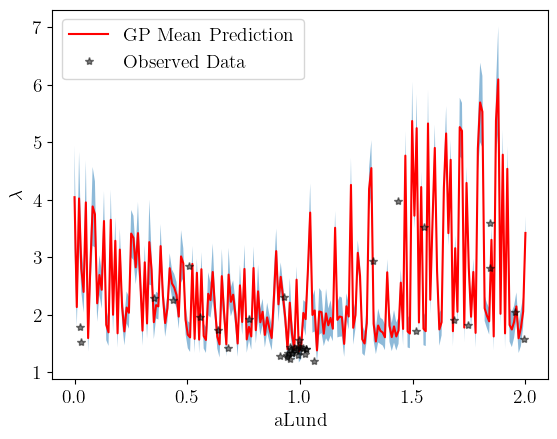

In [124]:
plot_model_param(model, 'aLund')

/tmp/ipykernel_5429/703769390.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


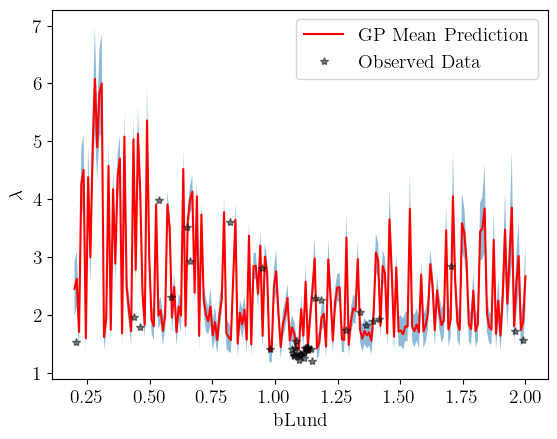

In [125]:
plot_model_param(model, 'bLund')

In [126]:
best_observed_params =get_observed_best_parameters(model)
best_observed_params

{'aLund': 1.063178300857544, 'bLund': 1.1469459533691406}